# Mamba MCMC for an LMM with one simple, scalar term

In [3]:
addprocs(4);
using Compat,DataFrames,Distributions,GraphViz,Mamba,RCall

In [4]:
ds = DataFrames.DataFrame("lme4::Dyestuff")
dump(ds)

DataFrame  30 observations of 2 variables
  Batch: PooledDataArray{ASCIIString,Uint8,1}(30) ASCIIString["A","A","A","A"]
  Yield: DataArray{Float64,1}(30) [1545.0,1440.0,1440.0,1520.0]


Create a `Dict{Symbol,Any}` containing the response and model matrices `X`, for the fixed-effects, and `Z`, for the random effects.

In [6]:
dsdat = @compat Dict{Symbol,Any}(
  :y => convert(Vector{Float64},DataArrays.array(ds[:Yield])),
  :Zt => StatsBase.indicatormat(ds[:Batch]),
  :X => ones(30,1)
)
dsdat[:Zty] = dsdat[:Zt] * dsdat[:y]
dsdat[:Xty] = dsdat[:X]'dsdat[:y]

1-element Array{Float64,1}:
 45825.0

In [7]:
b = randn(6)         # initial values for random effects
β = mean(dsdat[:y])  # initial value for β
λ = 1.               # initial value for σ₁/σ

1527.5

In [13]:
dsdat[:X]*β + dsdat[:Zt]'b

30x1 Array{Float64,2}:
 1528.42
 1528.42
 1528.42
 1528.42
 1528.42
 1526.91
 1526.91
 1526.91
 1526.91
 1526.91
 1527.3 
 1527.3 
 1527.3 
    ⋮   
 1526.14
 1526.14
 1529.72
 1529.72
 1529.72
 1529.72
 1529.72
 1526.91
 1526.91
 1526.91
 1526.91
 1526.91

In [17]:
dsmod = Model(
  μ = Logical(1, @modelexpr(β,b,X,Zt,vec(X*β+Zt'b)), false),
  σ = Logical(1, @modelexpr(logσ,exp(logσ)),false),
  y = Stochastic(1, @modelexpr(μ,σ,MvNormal(μ,σ)),false),
  logσ = Stochastic(1, :(Flat()), true),
  λ = Stochastic(1, :(Gamma(1,1)), true),
  β = Stochastic(1, :(Flat()), true),
  b = Stochastic(1, @modelexpr(σ, λ, MvNormal(6, λ*σ)), false)
);

In [18]:
draw(dsmod,filename="foo.dot");

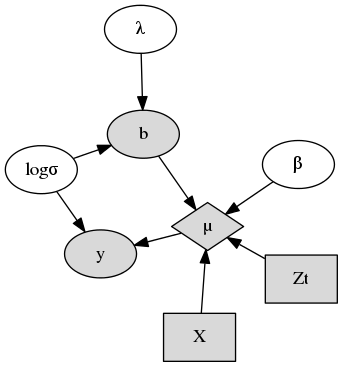

In [19]:
open("foo.dot","r") do io Graph(io) end

In [39]:
Gibbs_b = Sampler([:b],
@modelexpr(b,β,y,Zt,X,logσ,logσb,
begin
    I = eye(size(Zt,1))
    Λ = exp(logσb - logσ)*I
    ΛtZt = Λ'Zt
    L = cholfact(ΛtZt*ΛtZt' + I)
    rand(MvNormal(vec(L\(ΛtZt*(y-X*β)))))
end));    